In [1]:
import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [16]:
import numpy as np
import sklearn.datasets
import time
import random

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (Evolution,
                   prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from gan_train import train_gan
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           visualize_fake_data_projection,
                           discriminator_2d_visualization,
                           mh_sampling_visualize,
                           epoch_visualization)
from mh_2d_sampling import mh_sampling
from ebm_sampling import (calculate_energy,
                          Langevin_sampling, 
                          MALA_sampling,
                          NUTS_sampling)

In [4]:
from sklearn.preprocessing import StandardScaler
random_seed = 42
train_dataset_size = 64000
sigma = 0.05

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [5]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [6]:
import glob
discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [7]:
G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

<All keys matched successfully>

In [8]:
epoch = 1000
path_to_save = None
batch_size_sample = 5000  

In [9]:
G = G.to(device)
D = D.to(device)

In [10]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

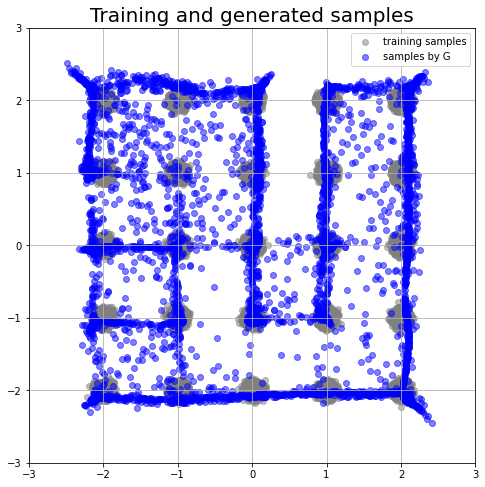

In [18]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

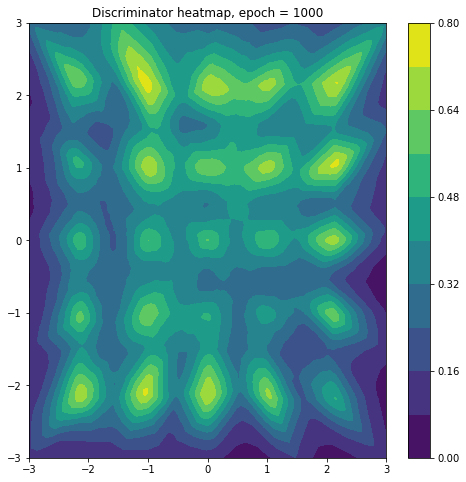

In [19]:
x_range = 3.0
y_range = 3.0
discriminator_2d_visualization(D,
                               x_range,
                               y_range,
                               path_to_save,
                               epoch,
                               scaler = scaler,
                               num_points = 700)

  0%|          | 0/5000 [00:00<?, ?it/s]

Start to do MH sampling....


100%|██████████| 5000/5000 [01:09<00:00, 72.38it/s]


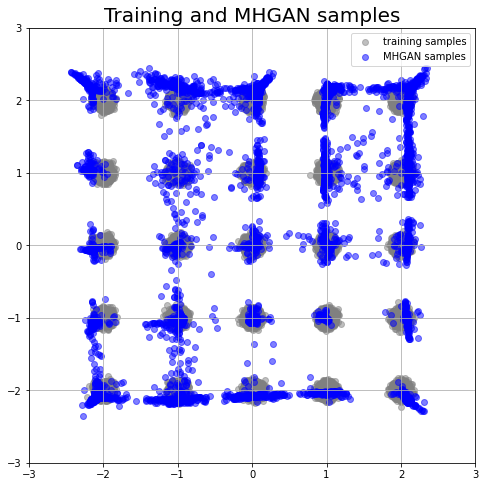

In [20]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_visualize(G, 
                      D,
                      X_train, epoch, 
                      path_to_save,
                      n_calib_pts = n_calib_pts,
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      type_calibrator = type_calibrator,
                      normalize_to_0_1 = normalize_to_0_1)

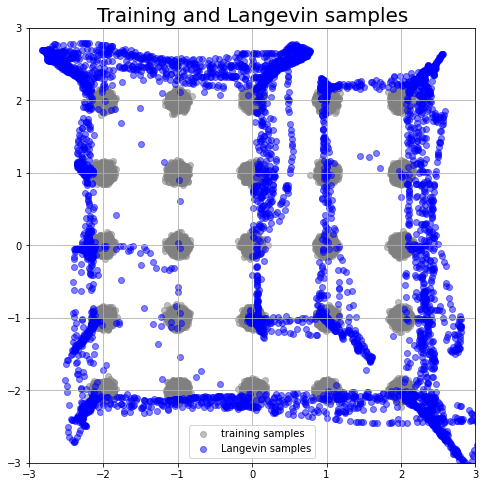

In [25]:
z_dim = G.n_dim
eps = 1e-3
num_iter = batch_size_sample
langevin_samples = Langevin_sampling(G, D, z_dim, eps, num_iter, device)
fake_langevin = G(langevin_samples).data.cpu().numpy()
mode = 'Langevin'
plot_fake_data_mode(fake_langevin, X_train, mode, path_to_save, 
                    scaler = scaler)

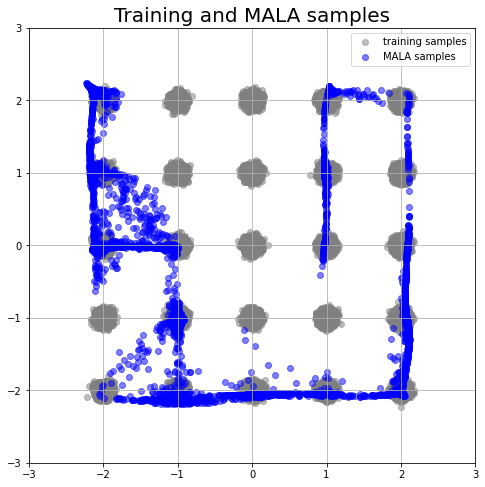

In [28]:
z_dim = G.n_dim
eps = 1e-3
num_iter = batch_size_sample
mala_samples = MALA_sampling(G, D, z_dim, eps, num_iter, device)
fake_mala = G(mala_samples).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)

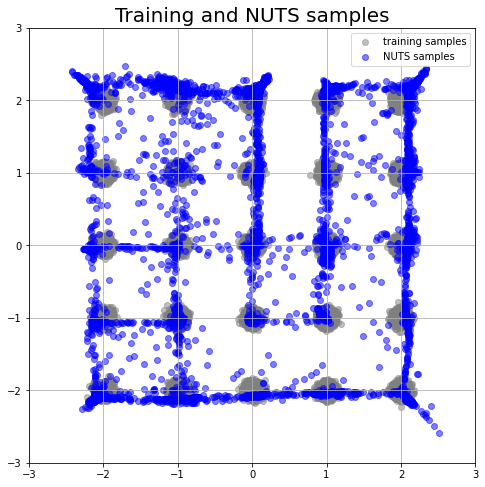

In [31]:
fake_nuts = G(nuts_samples[0]).data.cpu().numpy()
mode = 'NUTS'
plot_fake_data_mode(fake_nuts, X_train, mode, path_to_save, 
                    scaler = scaler)

In [23]:
def visualize_potential_energy(discriminator,
                               generator,
                               x_range,
                               y_range,
                               normalize_to_0_1 = True,
                               num_points = 700):
    x = torch.linspace(-x_range, x_range, num_points)
    y = torch.linspace(-y_range, y_range, num_points)
    x_t = x.view(-1, 1).repeat(1, y.size(0))
    y_t = y.view(1, -1).repeat(x.size(0), 1)
    x_t_batch = x_t.view(-1 , 1)
    y_t_batch = y_t.view(-1 , 1)
    batch = torch.zeros((x_t_batch.shape[0], 2))
    batch[:, 0] = x_t_batch[:, 0]
    batch[:, 1] = y_t_batch[:, 0]
    batch = batch.to(discriminator.device)
    generator_batch = generator(batch)
    
    dist_batch = (torch.norm(batch, p=2, dim=-1) ** 2)/2.0
    dist_batch = dist_batch.to(discriminator.device)

    if normalize_to_0_1:
        discr_batch = -discriminator(generator_batch).view(-1)
    else:
        discr_batch = -discriminator(generator_batch).sigmoid().view(-1)
    
    result = discr_batch + dist_batch
    heatmap = result.view((num_points, 
                           num_points)).detach().cpu().numpy()
    x_numpy = x.numpy()
    y_numpy = y.numpy()
    y, x = np.meshgrid(x_numpy, y_numpy)
    l_x=x_numpy.min()
    r_x=x_numpy.max()
    l_y=y_numpy.min()
    r_y=y_numpy.max()
    #small_heatmap = sigmoid_heatmap[:-1, :-1]
    figure, axes = plt.subplots(figsize=(8, 8))
    z = axes.contourf(x, y, heatmap, 10, cmap='viridis')
    title = f"Latent energy"
    axes.set_title(title)
    axes.axis([l_x, r_x, l_y, r_y])
    figure.colorbar(z)

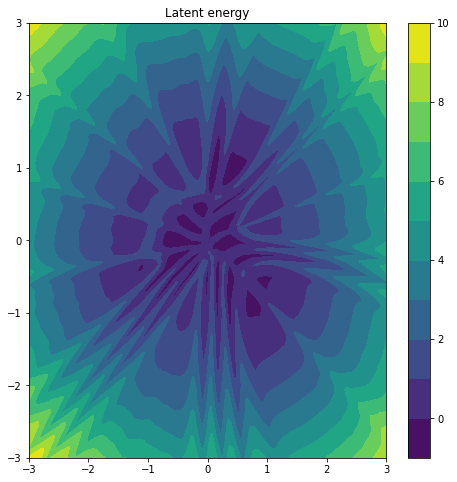

In [24]:
x_range = 3.0
y_range = 3.0
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range)

In [101]:
def calculate_energy(params, generator, discriminator):
    generator_points = generator(params)
    GAN_part = -discriminator(generator_points).view(-1)
    prior_part = (torch.norm(params, p=2, dim=-1) ** 2)/2
    return (GAN_part + prior_part).sum()


def visualize_norm_grads_potential_energy(discriminator,
                                          generator,
                                          x_range,
                                          y_range,
                                          num_points = 100):
    x = torch.linspace(-x_range, x_range, num_points)
    y = torch.linspace(-y_range, y_range, num_points)
    x_t = x.view(-1, 1).repeat(1, y.size(0))
    y_t = y.view(1, -1).repeat(x.size(0), 1)
    x_t_batch = x_t.view(-1 , 1)
    y_t_batch = y_t.view(-1 , 1)
    batch = torch.zeros((x_t_batch.shape[0], 2))
    batch[:, 0] = x_t_batch[:, 0]
    batch[:, 1] = y_t_batch[:, 0]

    batch = batch.to(discriminator.device)
    energy_fun = partial(calculate_energy, 
                         generator = generator,
                         discriminator = discriminator)
    batch.requires_grad_(True)
    batch_energy = energy_fun(batch).sum()
    batch_energy.backward()
    batch_grads = batch.grad.detach().cpu()
    batch_grads_norm = torch.norm(batch_grads, p=2, dim=-1)
    batch_grads_norm = batch_grads_norm.view((num_points, 
                                              num_points)).detach().cpu().numpy()
    
    x_numpy = x.numpy()
    y_numpy = y.numpy()
    y, x = np.meshgrid(x_numpy, y_numpy)
    l_x=x_numpy.min()
    r_x=x_numpy.max()
    l_y=y_numpy.min()
    r_y=y_numpy.max()
    #small_heatmap = sigmoid_heatmap[:-1, :-1]
    figure, axes = plt.subplots(figsize=(8, 8))
    z = axes.contourf(x, y, batch_grads_norm, 10, cmap='viridis')
    title = f"Latent energy norm gradients"
    axes.set_title(title)
    axes.axis([l_x, r_x, l_y, r_y])
    figure.colorbar(z)
    return batch_grads

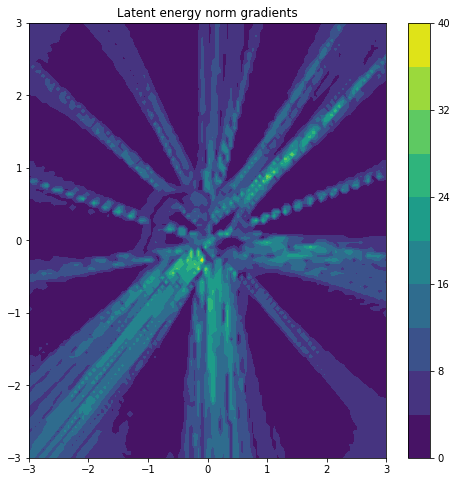

In [102]:
x_range = 3.0
y_range = 3.0
batch_grads = visualize_norm_grads_potential_energy(D,
                                      G,
                                      x_range,
                                      y_range)

In [105]:
energy_fun = partial(calculate_energy, 
                     generator = G,
                     discriminator = D)
point = torch.Tensor([[1.0, -0.5], [1.0, -0.2]]).to(D.device)
point.requires_grad_(True)
batch_energy = energy_fun(point)
batch_energy.backward()
print(point.grad)

tensor([[ 0.1490,  2.5423],
        [ 1.3375, 19.5395]], device='cuda:0')


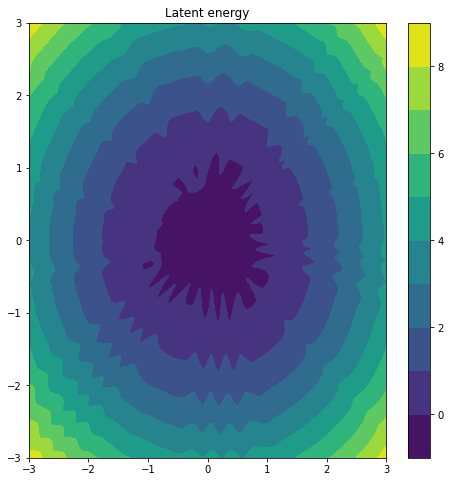

In [56]:
x_range = 3.0
y_range = 3.0
visualize_potential_energy(D,
                           G,
                           x_range,
                           y_range,
                           normalize_to_0_1 = False)

Sample: 100%|██████████| 10000/10000 [08:50, 18.84it/s, step size=5.35e-02, acc. prob=0.830]


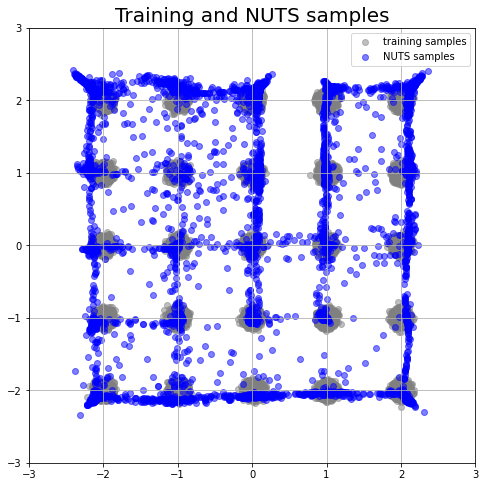

In [11]:
z_dim = G.n_dim
num_iter = batch_size_sample
latent_arr, mcmc = NUTS_sampling(G, D, z_dim, batch_size_sample, device)
fake_nuts = G(latent_arr).data.cpu().numpy()
mode = 'NUTS'
plot_fake_data_mode(fake_nuts, X_train, mode, path_to_save, 
                    scaler = scaler)

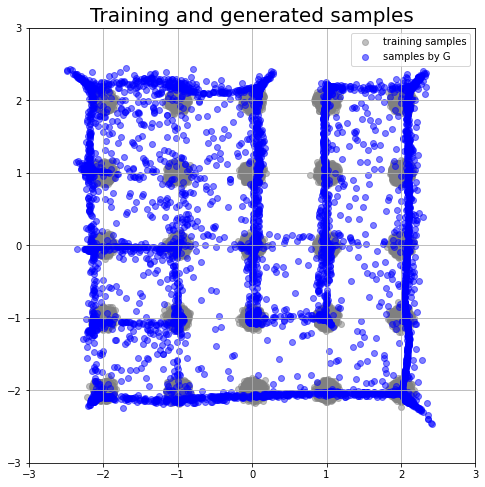

In [12]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

In [20]:
def calculate_energy(params, generator, discriminator):
   if params is not None:
      GAN_part = -discriminator(generator(params)).view(-1)
      prior_part = (torch.norm(params, p=2, dim=-1) ** 2)/2
      result = (GAN_part + prior_part).sum()
      return result
   else:
      return torch.tensor([0.0])

In [30]:
z_dim = 2
energy_fun = partial(calculate_energy, 
                     generator = G,
                     discriminator = D)
num_iter = 5000
eps = 1e-3

In [31]:
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)
uniform_sampler = Uniform(low = 0.0, high = 1.0)
cur_z = torch.tensor([0.0, 0.0], device = device)
cur_z.requires_grad_(True)
latent_arr = [cur_z.clone()]
#print(f"Start latent point = {cur_z.detach().cpu()}, image = {G(cur_z).detach().cpu()}")
for i in range(num_iter):
    cur_energy = energy_fun(cur_z)
    cur_energy.backward()
    noise = diagn.sample()
    gamma = eps/2
    with torch.no_grad():
        new_z = (cur_z - gamma*cur_z.grad + (eps ** 0.5)*noise)
    new_z = new_z.clone()
    new_z.requires_grad_(True)
    new_energy = energy_fun(new_z)
    new_energy.backward()
    energy_part = cur_energy - new_energy
    with torch.no_grad():
        vec_for_propose_2 = cur_z - new_z + gamma*new_z.grad
    propose_part_2 = (vec_for_propose_2 @ vec_for_propose_2)/4.0/gamma
    propose_part = (noise @ noise)/2.0 - propose_part_2
    log_accept_prob = propose_part + energy_part
    generate_uniform_var = uniform_sampler.sample().to(device)
    log_generate_uniform_var = torch.log(generate_uniform_var)
    if log_generate_uniform_var < log_accept_prob:
        latent_arr.append(new_z.clone())
        cur_z = new_z
        cur_z.grad.data.zero_()
        #print(f"New latent point = {cur_z.detach().cpu()}, image = {G(cur_z).detach().cpu()}")

latent_arr = torch.stack(latent_arr, dim = 0)

In [33]:
latent_arr.shape

torch.Size([4918, 2])

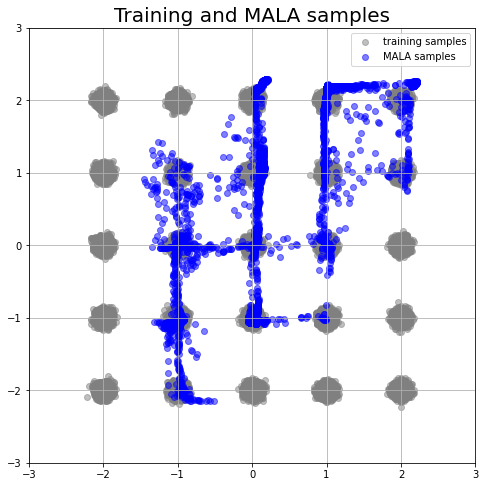

In [32]:
fake_mala = G(latent_arr).data.cpu().numpy()
mode = 'MALA'
plot_fake_data_mode(fake_mala, X_train, mode, path_to_save, 
                    scaler = scaler)